In [36]:
#%matplotlib widget

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import auxFuncs as aux
import HbXConcentrations as hbx
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import zoom

In [37]:
# Load sample MC simulations

imagesMC1, shapeImagesMC1 = aux.loadMatStruct("MC2Inc660_2.mat", "flux")
imagesMC2, shapeImagesMC2 = aux.loadMatStruct("MC2Inc830_2.mat", "flux")

imagesMC1CW, shapeImagesMC1CW = aux.loadMatStruct("Tomo_DosInc_reg_660posOrig_pared_a2cm.mat", "flux")
imagesMC2CW, shapeImagesMC2CW = aux.loadMatStruct("Tomo_DosInc_reg_830posOrig_pared_a2cm.mat", "flux")

GTHbO = np.loadtxt("groundTruth_HbO_posOrig.txt", delimiter=",")
GTHbR = np.loadtxt("groundTruth_HbR_posOrig.txt", delimiter=",")

basalHbO = GTHbO[0,0]
basalHbR = GTHbR[0,0]
GTHbO[GTHbO==basalHbO] = 0
GTHbR[GTHbR==basalHbR] = 0

np.shape(GTHbO)

(250, 250)

In [38]:
sigmaGauss = 12
fftStrength = 2
cropSizeX = 70
cropSizeY = 70
maxDev = 10
doTotMap = False
doSatMap = True
colorMap = "Spectral_r"

minValPos = 0
extent = [minValPos , 250, 250, minValPos]

# Without chest wall

In [39]:
# Perfom smoothing

for i in range(shapeImagesMC1[0]):
    imagesMC1[i] = aux.fftGauss(imagesMC1[i], fftStrength)[0]
    
for i in range(shapeImagesMC2[0]):
    imagesMC2[i] = aux.fftGauss(imagesMC2[i], fftStrength)[0]

In [40]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1[0],2))
centersPos2 = np.empty((shapeImagesMC2[0],2))

for i in range(shapeImagesMC1[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1[i], smooth=0)
    
for i in range(shapeImagesMC2[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2[i], smooth=0)

In [41]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [42]:
# Generate background normalization image

back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)

In [43]:
# Compute normalized crops

imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2

In [44]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights, reconShape=[250,250])
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights, reconShape=[250,250])


36it [00:00, 77.82it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/auxFuncs.py:234: RuntimeWarning: invalid value encountered in divide
  imageRecon = imageReconTemp/imageReconCount
36it [00:00, 79.04it/s]


In [45]:
#recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
#recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]
recon2DCrop1 = recon2DAll1
recon2DCrop2 = recon2DAll2

In [46]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D = HbXMaps_2D[:,:,1]
OxyMap_2D = HbXMaps_2D[:,:,0]
TotMap_2D = desOxyMap_2D + OxyMap_2D

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 15.59it/s]


Step 2/2...


100%|██████████| 36/36 [00:12<00:00,  2.82it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [47]:
import scipy as sc

desOxyMap_2D_filtered = sc.ndimage.median_filter(desOxyMap_2D,4)
OxyMap_2D_filtered = sc.ndimage.median_filter(OxyMap_2D,4)

#desOxyMap_2D_filtered = desOxyMap_2D
#OxyMap_2D_filtered = OxyMap_2D

desOxyMap_2D_filtered[desOxyMap_2D_filtered==np.nan] = 0
OxyMap_2D_filtered[OxyMap_2D_filtered==np.nan] = 0

np.savetxt("MC2Incs_HbRMap.dat", desOxyMap_2D_filtered)
np.savetxt("MC2Incs_HbOMap.dat", OxyMap_2D_filtered)

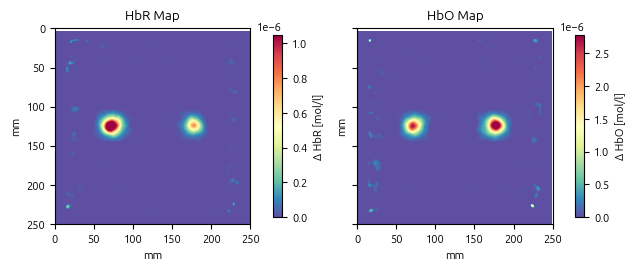

In [48]:
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)

if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered)
median = np.nanmedian(desOxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

sd = np.nanstd(OxyMap_2D_filtered)
median = np.nanmedian(OxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_2D = desOxyMap_2D_filtered + OxyMap_2D_filtered

        sd = np.nanstd(TotMap_2D)
        median = np.nanmedian(TotMap_2D)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        
        Tot.set_title("Total HB HBMap")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

plt.show()
figSats.savefig("MC2Incs_HbXMaps_noTot.png", bbox_inches='tight', dpi=300)

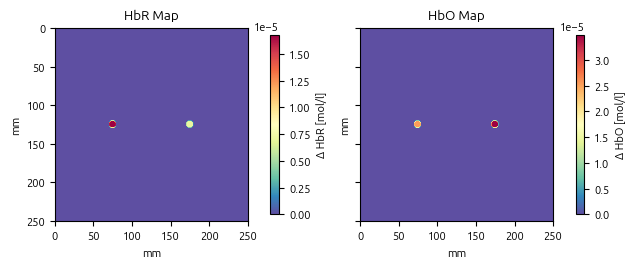

In [49]:
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)

if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(GTHbR)
median = np.nanmedian(GTHbR)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(GTHbR, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

sd = np.nanstd(GTHbO)
median = np.nanmedian(GTHbO)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(GTHbO, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_2D = GTHbO + GTHbR

        sd = np.nanstd(TotMap_2D)
        median = np.nanmedian(TotMap_2D)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        
        Tot.set_title("Total HB HBMap")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

plt.show()
figSats.savefig("MC2Incs_GroundTruths.png", bbox_inches='tight', dpi=300)

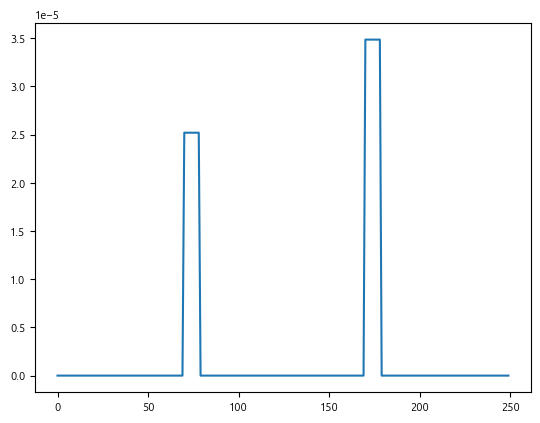

In [50]:
plt.plot(GTHbO[125,:])

0.8548015604583243 0.8776458699456275


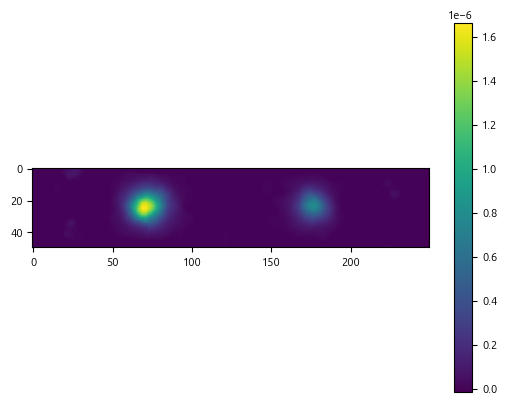

In [51]:
desOxyMap_2D_scaled = zoom(desOxyMap_2D_filtered, 250/np.shape(desOxyMap_2D_filtered)[0], order=1)
OxyMap_2D_scaled = zoom(OxyMap_2D_filtered, 250/np.shape(OxyMap_2D_filtered)[0], order=1)

desOxyMap_2D_scaled[desOxyMap_2D_scaled<0]=0
desOxyMap_2D_scaled[np.isnan(desOxyMap_2D_scaled)]=np.nanmean(desOxyMap_2D_filtered)

OxyMap_2D_scaled[OxyMap_2D_scaled<0]=0
OxyMap_2D_scaled[np.isnan(OxyMap_2D_scaled)]=np.nanmean(OxyMap_2D_filtered)

plt.imshow(desOxyMap_2D_scaled[100:150,:])
plt.colorbar()



ssimOxy_noCW = ssim(GTHbO[100:150,:], OxyMap_2D_scaled[100:150,:], data_range=np.max(GTHbO) - np.min(GTHbO))
ssimDesOxy_noCW = ssim(GTHbR[100:150,:], desOxyMap_2D_scaled[100:150,:], data_range=np.max(GTHbR) - np.min(GTHbR))

ssimOxy_noCW = ssim(GTHbO[100:150,:], OxyMap_2D_scaled[100:150,:], data_range=np.max(GTHbO) - np.min(GTHbO))
ssimDesOxy_noCW = ssim(GTHbR[100:150,:], desOxyMap_2D_scaled[100:150,:], data_range=np.max(GTHbR) - np.min(GTHbR))

print(ssimOxy_noCW, ssimDesOxy_noCW)

# With Chest Wall (2cm Depth)

In [52]:
# Perfom smoothing

for i in range(shapeImagesMC1[0]):
    imagesMC1CW[i] = aux.fftGauss(imagesMC1CW[i], fftStrength)[0]
    
for i in range(shapeImagesMC2[0]):
    imagesMC2CW[i] = aux.fftGauss(imagesMC2CW[i], fftStrength)[0]

In [53]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1CW[0],2))
centersPos2 = np.empty((shapeImagesMC2CW[0],2))

for i in range(shapeImagesMC1CW[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1CW[i], smooth=0)
    
for i in range(shapeImagesMC2CW[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2CW[i], smooth=0)

In [54]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1CW):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2CW):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [55]:
# Generate background normalization image

back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)
#plt.imshow(back1)

In [56]:
# Compute normalized crops

imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2
#plt.imshow(imagesDiv1[12])

In [57]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights, reconShape=[250,250])
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights, reconShape=[250,250])


36it [00:00, 76.92it/s]
36it [00:00, 75.81it/s]


In [58]:
#recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
#recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]
recon2DCrop1 = recon2DAll1
recon2DCrop2 = recon2DAll2

In [59]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D_CW = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D_CW = HbXMaps_2D_CW[:,:,1]
OxyMap_2D_CW = HbXMaps_2D_CW[:,:,0]
TotMap_2D_CW = desOxyMap_2D_CW + OxyMap_2D_CW

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


Step 2/2...


100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


In [60]:
import scipy as sc

desOxyMap_2D_filtered_CW = sc.ndimage.median_filter(desOxyMap_2D_CW,4)
OxyMap_2D_filtered_CW = sc.ndimage.median_filter(OxyMap_2D_CW,4)

#desOxyMap_2D_filtered = desOxyMap_2D
#OxyMap_2D_filtered = OxyMap_2D

desOxyMap_2D_filtered_CW[desOxyMap_2D_filtered_CW==np.nan] = 0
OxyMap_2D_filtered_CW[OxyMap_2D_filtered_CW==np.nan] = 0

np.savetxt("MC2Incs_CW_HbRMapW.dat", desOxyMap_2D_filtered_CW)
np.savetxt("MC2Incs_CW_HbOMap.dat", OxyMap_2D_filtered_CW)

In [61]:
np.shape(desOxyMap_2D_filtered_CW)

(250, 250)

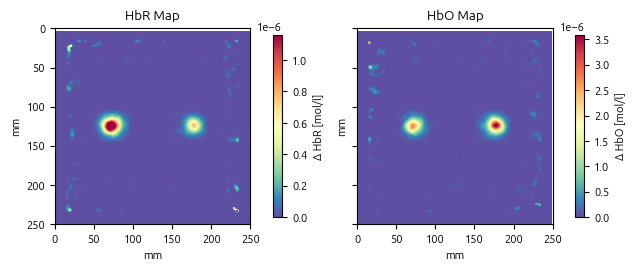

In [62]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)


if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered_CW)
median = np.nanmedian(desOxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered_CW, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

sd = np.nanstd(OxyMap_2D_filtered_CW)
median = np.nanmedian(OxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered_CW, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_2D = desOxyMap_2D_filtered_CW + OxyMap_2D_filtered_CW

        sd = np.nanstd(TotMap_2D_CW)
        median = np.nanmedian(TotMap_2D_CW)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D_CW, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        
        Tot.set_title("Total HB HBMap")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()
plt.show()

figSats.savefig("MC2Incs_HbXMaps_noTot_ChestWall.png", bbox_inches='tight', dpi=300)

0.8495830372220222 0.8741314154759582


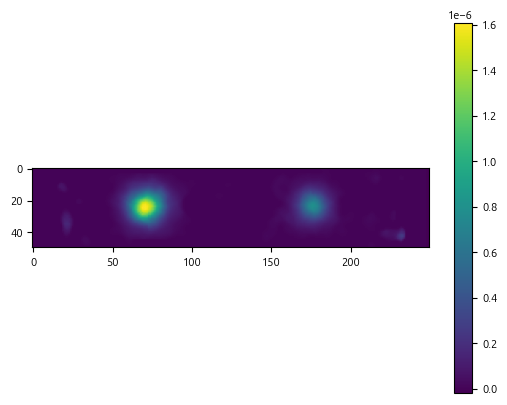

In [63]:
desOxyMap_2D_scaled_CW = zoom(desOxyMap_2D_filtered_CW, 250/np.shape(desOxyMap_2D_filtered_CW)[0], order=1)
OxyMap_2D_scaled_CW = zoom(OxyMap_2D_filtered_CW, 250/np.shape(OxyMap_2D_filtered_CW)[0], order=1)

desOxyMap_2D_scaled_CW[desOxyMap_2D_scaled_CW<0]=0
desOxyMap_2D_scaled_CW[np.isnan(desOxyMap_2D_scaled_CW)]=np.nanmean(desOxyMap_2D_filtered)

OxyMap_2D_scaled_CW[OxyMap_2D_scaled_CW<0]=0
OxyMap_2D_scaled_CW[np.isnan(OxyMap_2D_scaled_CW)]=np.nanmean(OxyMap_2D_filtered_CW)

plt.imshow(desOxyMap_2D_scaled_CW[100:150,:])
plt.colorbar()



ssimOxy_CW = ssim(GTHbO[100:150,:], OxyMap_2D_scaled_CW[100:150,:], data_range=np.max(GTHbO) - np.min(GTHbO))
ssimDesOxy_CW = ssim(GTHbR[100:150,:], desOxyMap_2D_scaled_CW[100:150,:], data_range=np.max(GTHbR) - np.min(GTHbR))

ssimOxy_CW = ssim(GTHbO[100:150,:], OxyMap_2D_scaled_CW[100:150,:], data_range=np.max(GTHbO) - np.min(GTHbO))
ssimDesOxy_CW = ssim(GTHbR[100:150,:], desOxyMap_2D_scaled_CW[100:150,:], data_range=np.max(GTHbR) - np.min(GTHbR))

print(ssimOxy_CW, ssimDesOxy_CW)

2.932298936404745e-07 9.41156513097057e-08


/tmp/ipykernel_16980/4192292028.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


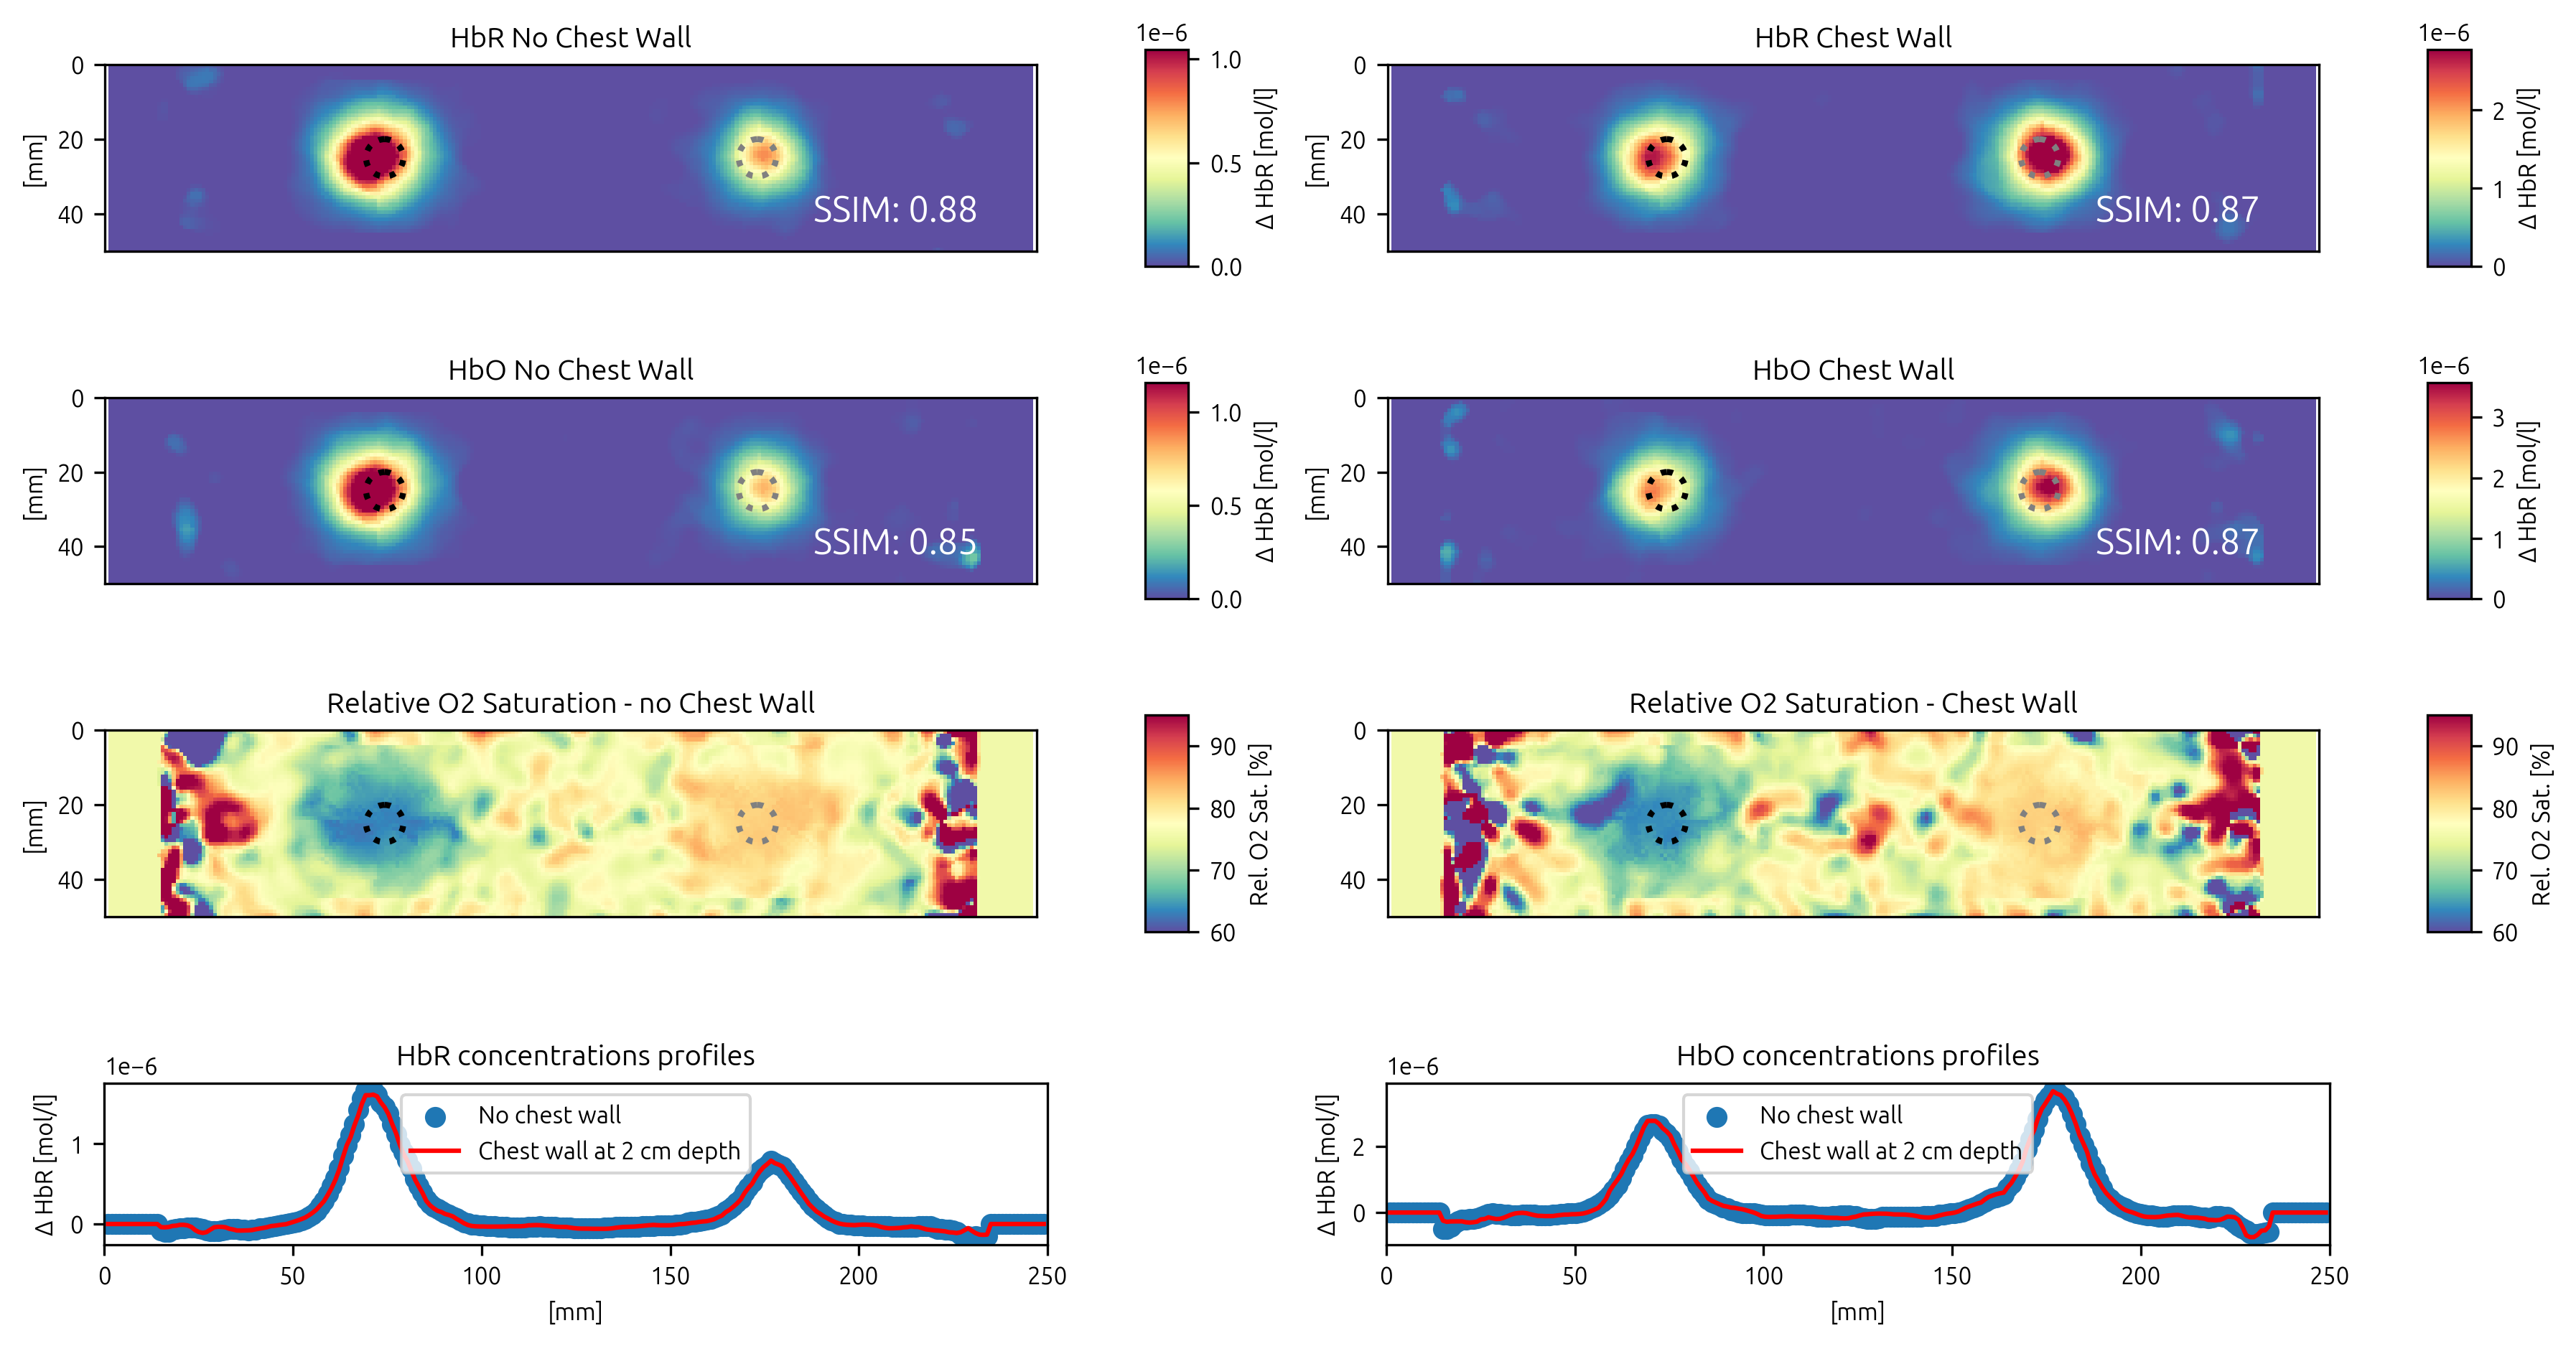

In [66]:
minValPos = 15
vertSize = 25

offsetX = 0

midVertPoint = int(np.shape(desOxyMap_2D_filtered)[0]/2)

extent = [0, 250, vertSize*2, 0]

incLineStyle = ":"
incLineWidth = 2
inc1Color = "black"
inc2Color = "grey"
incRad = 5

inc1Pos = [75, vertSize]
inc2Pos = [175, vertSize]

maxDev = 10

if doSatMap:
    fig, axs = plt.subplots(3, 2, figsize=(12, 5), dpi=300)
else:
    fig, axs = plt.subplots(2, 2, figsize=(12, 5), dpi=300)


plt.subplots_adjust(hspace=0.)  # Adjust the vertical spacing between subplots

sd = np.nanstd(desOxyMap_2D_filtered)
median = np.nanmedian(desOxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0
imHbRnoCW = axs[0, 0].imshow(desOxyMap_2D_filtered[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
inc1Circ = patches.Circle(inc1Pos, radius=incRad,
                            edgecolor=inc1Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
inc2Circ = patches.Circle(inc2Pos, radius=incRad,
                            edgecolor=inc2Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
axs[0, 0].add_patch(inc1Circ)
axs[0, 0].add_patch(inc2Circ)

cbarHbRnoCW = fig.colorbar(imHbRnoCW, ax=axs[0, 0], fraction=0.04, pad=0.1, aspect=5)
cbarHbRnoCW.set_label("Δ HbR [mol/l]")
axs[0, 0].text(190, 42, "SSIM: {0:.2f}".format(ssimDesOxy_noCW), fontsize=12, c="white")
axs[0, 0].set_title("HbR No Chest Wall")
axs[0, 0].set_ylabel("[mm]")
axs[0, 0].get_xaxis().set_visible(False)

sd = np.nanstd(OxyMap_2D_filtered)
median = np.nanmedian(OxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0
imHbOnoCW = axs[0, 1].imshow(OxyMap_2D_filtered[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
inc1Circ = patches.Circle(inc1Pos, radius=incRad,
                            edgecolor=inc1Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
inc2Circ = patches.Circle(inc2Pos, radius=incRad,
                            edgecolor=inc2Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
axs[0, 1].add_patch(inc1Circ)
axs[0, 1].add_patch(inc2Circ)

cbarHbOnoCW = fig.colorbar(imHbOnoCW, ax=axs[0, 1], fraction=0.04, pad=0.1, aspect=5)
cbarHbOnoCW.set_label("Δ HbR [mol/l]")
axs[1, 0].text(190, 42, "SSIM: {0:.2f}".format(ssimOxy_noCW), fontsize=12, c="white")
axs[1, 0].set_title("HbO No Chest Wall")
axs[1, 0].set_ylabel("[mm]")
axs[1, 0].get_xaxis().set_visible(False)

sd = np.nanstd(desOxyMap_2D_filtered_CW)
median = np.nanmedian(desOxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0
imHbRCW = axs[1, 0].imshow(desOxyMap_2D_filtered_CW[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
inc1Circ = patches.Circle(inc1Pos, radius=incRad,
                            edgecolor=inc1Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
inc2Circ = patches.Circle(inc2Pos, radius=incRad,
                            edgecolor=inc2Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
axs[1, 0].add_patch(inc1Circ)
axs[1, 0].add_patch(inc2Circ)


cbarHbRCW = fig.colorbar(imHbRCW, ax=axs[1,0], fraction=0.04, pad=0.1, aspect=5)
cbarHbRCW.set_label("Δ HbR [mol/l]")
axs[0, 1].text(190, 42, "SSIM: {0:.2f}".format(ssimDesOxy_CW), fontsize=12, fontweight=1000, c="white")
axs[0, 1].set_title("HbR Chest Wall")
axs[0, 1].set_ylabel("[mm]")
axs[0, 1].get_xaxis().set_visible(False)

sd = np.nanstd(OxyMap_2D_filtered_CW)
median = np.nanmedian(OxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0
imHbOCW = axs[1, 1].imshow(OxyMap_2D_filtered_CW[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
inc1Circ = patches.Circle(inc1Pos, radius=incRad,
                            edgecolor=inc1Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
inc2Circ = patches.Circle(inc2Pos, radius=incRad,
                            edgecolor=inc2Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
axs[1, 1].add_patch(inc1Circ)
axs[1, 1].add_patch(inc2Circ)



cbarHbOCW = fig.colorbar(imHbOCW, ax=axs[1, 1], fraction=0.04, pad=0.1, aspect=5)
cbarHbOCW.set_label("Δ HbR [mol/l]")
axs[1, 1].text(190, 42, "SSIM: {0:.2f}".format(ssimDesOxy_CW), fontsize=12, c="white")
axs[1, 1].set_title("HbO Chest Wall")
axs[1, 1].set_ylabel("[mm]")
axs[1, 1].get_xaxis().set_visible(False)


if doSatMap:

    HbOminVal = np.abs(np.nanpercentile(aux.fftGauss(OxyMap_2D_filtered, 10)[0],1))
    HbRminVal = np.abs(np.nanpercentile(aux.fftGauss(desOxyMap_2D_filtered, 10)[0],1))
    print(HbOminVal, HbRminVal)

    O2SatMap_noCW = (OxyMap_2D_filtered+HbOminVal)/((OxyMap_2D_filtered +
                                                          HbOminVal) + (desOxyMap_2D_filtered+HbRminVal))
    O2SatMap_CW = (OxyMap_2D_filtered_CW+HbOminVal)/((OxyMap_2D_filtered_CW +
                                                          HbOminVal) + (desOxyMap_2D_filtered_CW+HbRminVal))

    vmax = 95
    vmin = 60
    imO2SatnoCW= axs[2, 0].imshow(O2SatMap_noCW[midVertPoint-vertSize:midVertPoint +
                                   vertSize, :]*100, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
    inc1Circ = patches.Circle(inc1Pos, radius=incRad,
                            edgecolor=inc1Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
    inc2Circ = patches.Circle(inc2Pos, radius=incRad,
                            edgecolor=inc2Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
    axs[2, 0].add_patch(inc1Circ)
    axs[2, 0].add_patch(inc2Circ)
    
    cbarO2SatnoCW = fig.colorbar(imO2SatnoCW, ax=axs[2, 0], fraction=0.04, pad=0.1, aspect=5)
    cbarO2SatnoCW.set_label("Rel. O2 Sat. [%]")
    axs[2, 0].set_title("Relative O2 Saturation - no Chest Wall")
    axs[2, 0].set_ylabel("[mm]")
    axs[2, 0].get_xaxis().set_visible(False)

    imO2SatCW= axs[2, 1].imshow(O2SatMap_CW[midVertPoint-vertSize:midVertPoint +
                                   vertSize, :]*100, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
    inc1Circ = patches.Circle(inc1Pos, radius=incRad,
                            edgecolor=inc1Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
    inc2Circ = patches.Circle(inc2Pos, radius=incRad,
                            edgecolor=inc2Color, facecolor='none', linestyle=incLineStyle, linewidth=incLineWidth)
    axs[2, 1].add_patch(inc1Circ)
    axs[2, 1].add_patch(inc2Circ)

    cbarO2SatCW = fig.colorbar(imO2SatCW, ax=axs[2, 1], fraction=0.04, pad=0.1, aspect=5)
    cbarO2SatCW.set_label("Rel. O2 Sat. [%]")
    axs[2, 1].set_title("Relative O2 Saturation - Chest Wall")
    axs[2, 1].get_xaxis().set_visible(False)



prof_HbR_noCW = desOxyMap_2D_filtered[midVertPoint, :]
prof_HbO_noCW = OxyMap_2D_filtered[midVertPoint, :]
prof_HbR_CW = desOxyMap_2D_filtered_CW[midVertPoint, :]
prof_HbO_CW = OxyMap_2D_filtered_CW[midVertPoint, :]

x_scale = np.linspace(0,250,np.shape(desOxyMap_2D_filtered)[0])

plot1 = fig.add_axes([0.042, -0.2, 0.365, 0.15])
plot2 = fig.add_axes([0.538, -0.2, 0.365, 0.15])

plot1.scatter(x_scale, prof_HbR_noCW, label="No chest wall")
plot1.plot(x_scale, prof_HbR_CW, c="red", label="Chest wall at 2 cm depth")
plot1.set_ylabel("Δ HbR [mol/l]")
plot1.set_xlabel("[mm]")
plot1.set_xlim(0,250)
plot1.set_title("HbR concentrations profiles")
plot1.legend()

plot2.scatter(x_scale, prof_HbO_noCW, label="No chest wall")
plot2.plot(x_scale, prof_HbO_CW, c="red", label="Chest wall at 2 cm depth")
plot2.set_xlabel("[mm]")
plot2.set_ylabel("Δ HbR [mol/l]")
plot2.set_xlim(0,250)
plot2.set_title("HbO concentrations profiles")
plot2.legend()

fig.tight_layout()
fig.savefig("MC2Incs_ChestWall.png", bbox_inches='tight', dpi=300)
plt.show()

70 177


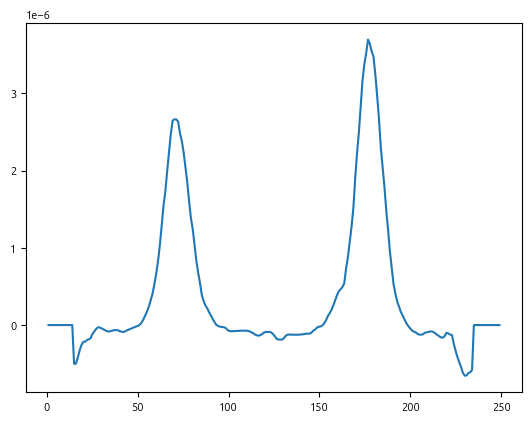

In [ ]:
plt.plot(x_scale, prof_HbO_noCW)
xPosInc1 = round(x_scale[np.nanargmax(prof_HbO_noCW[0:100])])
xPosInc2 = round(x_scale[150+np.nanargmax(prof_HbO_noCW[150:240])])
print(xPosInc1, xPosInc2)

124.49799196787149 124.49799196787149


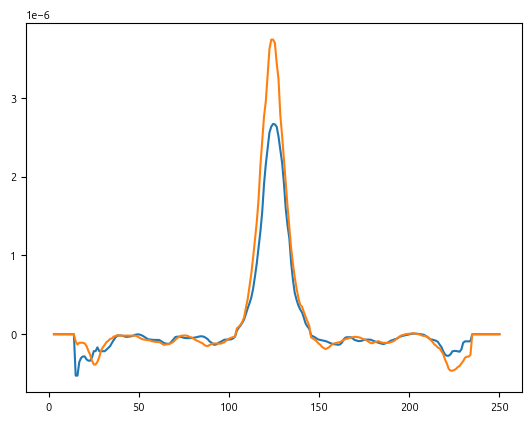

In [ ]:
y_scale = x_scale
profY_inc1_HbO_noCW = OxyMap_2D_filtered[:, np.nanargmax(prof_HbO_noCW[0:100])]
profY_inc2_HbO_noCW = OxyMap_2D_filtered[:, 150+np.nanargmax(prof_HbO_noCW[150:240])]

plt.plot(y_scale, profY_inc1_HbO_noCW)
plt.plot(y_scale, profY_inc2_HbO_noCW)
yPosInc1 = y_scale[np.nanargmax(profY_inc1_HbO_noCW)]
yPosInc2 = y_scale[np.nanargmax(profY_inc1_HbO_noCW)]
print(yPosInc1, yPosInc2)

In [ ]:
FWHMInc1 = aux.FWHM(y_scale,profY_inc1_HbO_noCW)
FWHMInc2 = aux.FWHM(y_scale,profY_inc2_HbO_noCW)
print(FWHMInc1, FWHMInc2)

[15.06024096] [15.06024096]
